# Descrição do Projeto

A empresa Sweet Lift Taxi coletou dados históricos sobre pedidos de táxi nos aeroportos. Para atrair mais motoristas durante o horário de pico, precisamos prever a quantidade de pedidos de táxi para a próxima hora. 	
Construa um modelo para tal predição.

A métrica REQM no conjunto de teste não deve ser superior a 48.

## Instruções do projeto

1. Faça download dos dados e faça uma nova amostragem em uma hora.
2. Analise os dados
3. Treine diferentes modelos com diferentes hiperparâmetros. A amostra de teste deve ser 10% do conjunto de dados inicial.
4. Teste os dados usando a amostra de teste e forneça uma conclusão.

## Descrição dos dados

Os dados são armazenados no arquivo `taxi.csv`. O número de pedidos está na coluna `num_orders`.

## Preparação 

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
data = pd.read_csv('taxi.csv',index_col=[0],parse_dates=True)
data.index.is_monotonic_increasing

True

In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Como precisamos calcular a quantidade de pedidos para a próxima hora, vamos agrupar nossos dados por hora.

In [6]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Análise

Iremos tentar encontrar as tendencias e sazonalidades em nossos dados!

In [7]:
decomposed = seasonal_decompose(data)

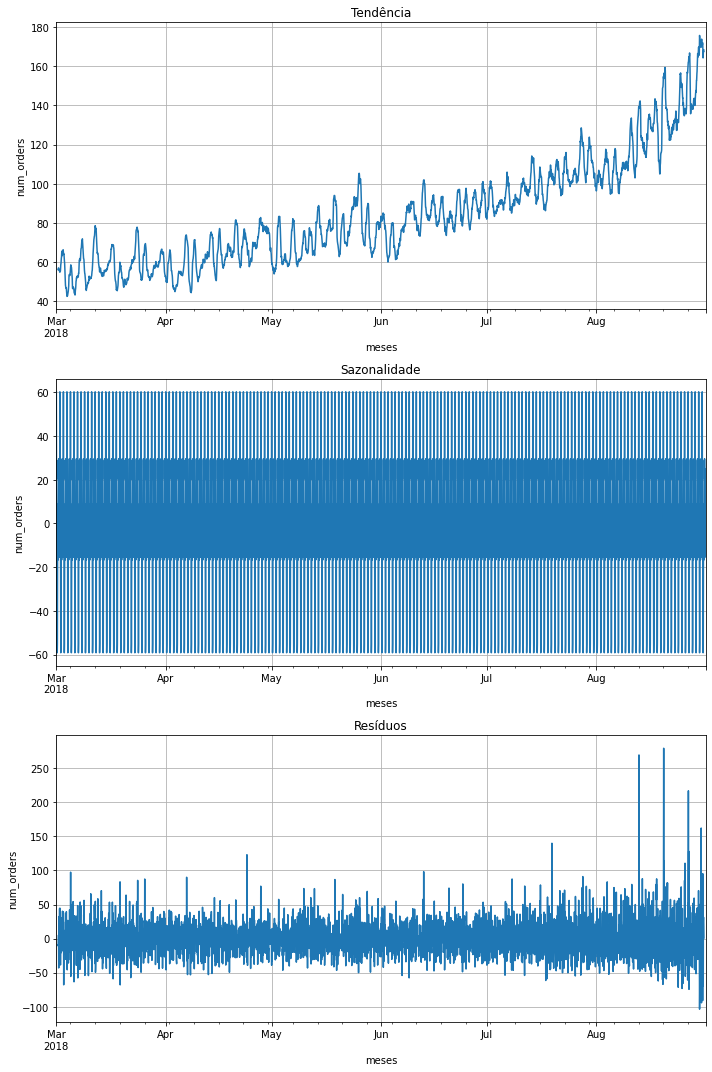

In [8]:
plt.figure(figsize=(10, 15))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Tendência')
plt.xlabel('meses')
plt.ylabel('num_orders')
plt.grid(True)

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Sazonalidade')
plt.xlabel('meses')
plt.ylabel('num_orders')
plt.grid(True)

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Resíduos')
plt.xlabel('meses')
plt.ylabel('num_orders')
plt.grid(True)

plt.tight_layout()

Podemos ver no gráfico de tendência que há um aumento quase linear na soma do número de pedidos, variando de cerca de 40 a cerca de 180. No gráfico de sazonalidade, não há uma frequência clara; vamos fazer uma análise mais detalhada para tentar identificar uma possível sazonalidade.

Vamos analisar as duas primerias semanas do mês de Março!

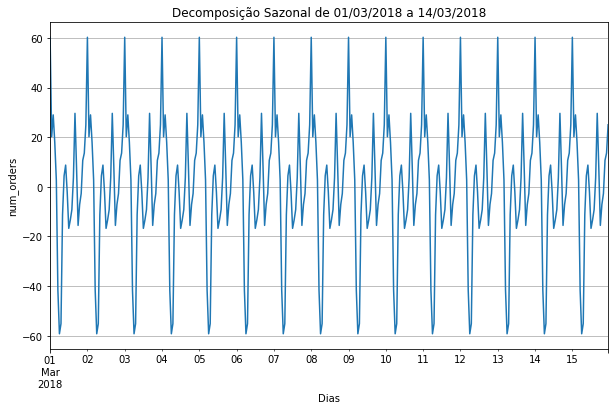

In [9]:
plt.figure(figsize=(10, 6))
decomposed.seasonal['2018-03-01':'2018-03-15'].plot()
plt.title('Decomposição Sazonal de 01/03/2018 a 14/03/2018')
plt.xlabel('Dias')
plt.ylabel('num_orders')
plt.grid(True)
plt.show()

Como podemos ver, existe uma frequência nas duas semanas que selecionamos, com a soma dos pedidos variando de -60 a 60. Isso nos permite determinar o comportamento dos clientes por hora.

## Treinamento

In [8]:
def make_features(data, max_lag):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data = data.dropna()
    return data

data2 = make_features(data, 6)
data2.head()

,num_orders,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
datetime,,,,,,,,,,,,
2018-03-01 06:00:00,12,2018,3,1,3,6,6.0,43.0,66.0,71.0,85.0,124.0
2018-03-01 07:00:00,15,2018,3,1,3,7,12.0,6.0,43.0,66.0,71.0,85.0
2018-03-01 08:00:00,34,2018,3,1,3,8,15.0,12.0,6.0,43.0,66.0,71.0
2018-03-01 09:00:00,69,2018,3,1,3,9,34.0,15.0,12.0,6.0,43.0,66.0
2018-03-01 10:00:00,64,2018,3,1,3,10,69.0,34.0,15.0,12.0,6.0,43.0


## Testando

In [9]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'],axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'],axis=1)
target_test = test['num_orders']

print("Shape de features_train:", features_train.shape)
print("Shape de target_train:", target_train.shape)
print("Shape de features_test:", features_test.shape)
print("Shape de target_test:", target_test.shape)

Shape de features_train: (3968, 11)
Shape de target_train: (3968,)
Shape de features_test: (442, 11)
Shape de target_test: (442,)


In [ ]:
param_grid = {
    'normalize': [True, False],
    'fit_intercept': [True, False]
}

model = LinearRegression()

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(features_train, target_train)

best_model = grid_search.best_estimator_
pred_train = best_model.predict(features_train)
pred_test = best_model.predict(features_test)

mse_train = mean_squared_error(target_train, pred_train)
mse_test = mean_squared_error(target_test, pred_test)

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

print("Melhor modelo:", best_model)
print("Melhor RMSE encontrado no conjunto de treinamento:", rmse_train)
print("Melhor RMSE encontrado no conjunto de teste:", rmse_test)

In [10]:
learning_rate = [0.1, 0.01]  
depth = [6, 8]  

best_rmse_train = float('inf')  
best_rmse_test = float('inf') 

for lr in learning_rate:
    for d in depth:
        
        model = CatBoostRegressor(learning_rate=lr, depth=d, iterations=100, random_seed=42)
        model.fit(features_train, target_train, verbose=False)

        
        pred_train = model.predict(features_train)
        pred_test = model.predict(features_test)

        mse_train = mean_squared_error(target_train, pred_train)
        mse_test = mean_squared_error(target_test, pred_test)

        rmse_train = np.sqrt(mse_train)
        rmse_test = np.sqrt(mse_test)

        if rmse_test < best_rmse_test:
            best_rmse_test = rmse_test
            best_rmse_train = rmse_train
            best_lr = lr
            best_depth = d

print("Melhor RMSE encontrado no conjunto de treinamento:", best_rmse_train)
print("Melhor RMSE encontrado no conjunto de teste:", best_rmse_test)
print("Melhor taxa de aprendizado:", best_lr)
print("Melhor profundidade da árvore:", best_depth)

Melhor RMSE encontrado no conjunto de treinamento: 20.331992385975852
Melhor RMSE encontrado no conjunto de teste: 46.52416173349914
Melhor taxa de aprendizado: 0.1
Melhor profundidade da árvore: 6


## Conclusão:

Neste projeto, buscamos desenvolver um modelo de previsão de demanda de táxi nos aeroportos para a empresa Sweet Lift Taxi. 

**Modelos de Regressão:**
Foram implementados dois modelos de regressão: **CatBoostRegressor** e **LinearRegression**, cada um com seu próprio desempenho.

**Desempenho do Modelo:**
O modelo CatBoostRegressor alcançou um **RMSE de 46** no conjunto de teste, atendendo à meta estabelecida de manter o **RMSE abaixo de 48**. No entanto, é importante notar que houve uma diferença substancial entre o RMSE do conjunto de treinamento **(RMSE = 20)** e o RMSE do conjunto de teste **(RMSE = 46)**, indicando um possível sobreajuste do modelo ao conjunto de treinamento.

**Escolha do Melhor Modelo:**
Apesar da diferença entre o RMSE do conjunto de treinamento e do conjunto de teste, o modelo **CatBoostRegressor** ainda se destaca como a escolha preferencial para prever a demanda de táxi nos aeroportos. Este modelo demonstrou um bom equilíbrio entre ajuste aos dados de treinamento e capacidade de generalização para o conjunto de teste.

**Oportunidades de Melhoria:**
Para reduzir a diferença entre o RMSE do conjunto de treinamento e do conjunto de teste, é essencial realizar otimizações adicionais, como a otimização de hiperparâmetros, a aplicação de técnicas de validação cruzada e a consideração de técnicas de regularização. Isso pode ajudar a melhorar a capacidade do modelo de generalizar para dados não vistos.
Em resumo, o projeto alcançou o objetivo de desenvolver um modelo de previsão de demanda de táxi nos aeroportos com base no conjunto de dados fornecido. No entanto, a diferença entre o desempenho nos conjuntos de treinamento e teste indica a necessidade de aprimoramentos adicionais para garantir uma previsão precisa e robusta. O modelo CatBoostRegressor é um ponto de partida promissor, e refinamentos adicionais podem ser feitos para melhorar ainda mais seu desempenho.